In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyProblem():
    def __init__(self):
        super().__init__()
        self.cost = 0
        self.deflection = 0
        self.g1 = 0
        self.g2 = 0
        self.g3 = 0
        self.g4 = 0
        
        self.tau_dash = 0
        self.tau_dash2 = 0
        self.tau = 0
        self.sigma = 0
        self.pc = 0
    
    def evaluate(self, x): 
        #x:parameters
        
        self.cost = 1.10471 * x[0]**2 * x[1] + 0.04811*x[2]*x[3]*(14.0+x[1])
        self.deflection = 2.1952/ x[2]**3 / x[3]
        
        self.tau_dash = 6000/np.sqrt(2.0)/x[0]/x[1]
        self.tau_dash2 = 6000*(14+0.5*x[1])*np.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2))  /  (2*0.707*x[0]*x[1]*(x[1]**2/12+0.25*(x[1]**2+(x[0]+x[2])**2)))
        self.tau =np.sqrt(self.tau_dash**2 + self.tau_dash2**2 + x[1]*self.tau_dash*self.tau_dash2 / np.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2)))
        
        self.sigma = 504000/x[2]**2/x[3]
        self.pc = 64764.022*(1-0.0282346*x[2])*x[2]*x[3]**3
        
        self.g1 = self.tau-13600
        self.g2 = self.sigma-30000
        self.g3 = x[0]-x[3]
        self.g4 = 6000-self.pc
        
    
    def calc_loss(self, w):
        #w:weight
        return w*self.cost + (1-w)*self.deflection*1000 #だいたいオーダーをそろえるために1000倍した

In [3]:
def update_position(x, v):
    new_x = x + v
    return new_x

#粒子の速度の更新を行う関数
def update_velocity(x, v, pers, glob, k=0.5, ro_max=0.15):
    #パラメーターroはランダムに与える
    ro = [np.random.uniform(0, 0.15) for i in range(2)]
    #粒子速度の更新を行う
    new_v = k * v + ro[0] * (pers - x) + 3* ro[1] * (glob - x)
    #new_vy = k * vy + ro1 * (p["y"] - y) + ro2 * (g["y"] - y)
    return new_v

In [37]:
N = 100000
lower = np.array([0.125,0.1,0,0]) #lower
upper = np.array([10,10,10,5]) #upper

In [38]:
#重み固定でやってみる

Weight = 0.5

In [39]:
ps = np.array([np.random.uniform(lower,upper) for n in range(N)])
vs = np.array([[0.0,0.0,0.0,0.0] for n in range(N)])
personal_best_positions = ps.copy().copy()

personal_best_scores = []
for p in ps:
    problem = MyProblem()
    problem.evaluate(p)
    personal_best_scores.append(problem.calc_loss(Weight))



best_particle = np.argmin(personal_best_scores)
global_best_position = personal_best_positions[best_particle]

T = 100  #制限時間(ループの回数)
losses = []

In [40]:
for t in range(10):
    for n in range(N):
        problem = MyProblem()
        p = personal_best_positions[n] 
            
        #粒子の位置の更新を行う
        x_new = update_position(ps[n], vs[n])
        if (problem.g1<=0 and problem.g2<=0 and problem.g3<=0 and problem.g4<=0):
            ps[n] = x_new
            
        #粒子の速度の更新を行う
        vs[n] = update_velocity(ps[n], vs[n], p, global_best_position)
            
        #評価値を求める
        problem.evaluate(ps[n])
        score = problem.calc_loss(Weight)
        if (problem.g1<=0 and problem.g2<=0 and problem.g3<=0 and problem.g4<=0):
            continue
        else:
            score = np.abs(score)*100000
        
        #パーソナルベスト
        if score < personal_best_scores[n]:
            personal_best_scores[n] = score
            personal_best_positions[n] = ps[n]
                
    #グローバルベストの更新を行う
    best_particle = np.argmin(personal_best_scores)
    global_best_position = personal_best_positions[best_particle]
    
    losses.append(personal_best_scores[best_particle])

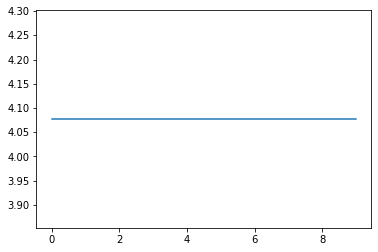

In [41]:
plt.plot(losses)

In [35]:
global_best_position

array([0.74377092, 0.55074604, 6.96425073, 1.51882681])

In [ ]:
for n in range(len(ps)):
    problem = MyProblem()
    problem.evaluate(ps[n])
    print(problem.g1<=0 and problem.g2<=0 and problem.g3<=0 and problem.g4<=0)

False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
True
True
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
True
True
False
False
False
False
False
False
True
False
False
False
True
True
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
False
False
False
True
True
False
False
False
True
False
False
True
False
False
False
False
False
True
False
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
Fals

## 制約を満たさない解が死なないのでとてもやりづらい